<a href="https://colab.research.google.com/github/TsvetaIvanova/ColabIMLO/blob/main/5_practical_IMLO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Get and process data


# Test

#Get full dataset into dataframe


In [1]:
import pandas as pd
from sklearn import datasets
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor, transforms
import time
from PIL import Image
from scipy.io import loadmat
import matplotlib.pyplot as plt


In [2]:
print(torch.__version__)
# !pip install torch==2.2.2

2.2.1+cu121


In [3]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")


Using cuda device


In [5]:
# # Basic transformation to convert images to tensor
# simple_transform = transforms.Compose([
#     transforms.ToTensor(),
# ])

# # Loading the dataset with basic transform
# train_set = datasets.Flowers102(root='data', split='train', download=True, transform=simple_transform)
# test_set = datasets.Flowers102(root='data', split='test', download=True, transform=simple_transform)
# val_set = datasets.Flowers102(root='data', split='val', download=True, transform=simple_transform)

# # Display basic dataset info
# print(f'Training Set: {len(train_set)} images')
# print(f'Test Set: {len(test_set)} images')
# print(f'Validation Set: {len(val_set)} images')

100%|██████████| 344862509/344862509 [00:27<00:00, 12387885.44it/s]


Extracting data/flowers-102/102flowers.tgz to data/flowers-102


100%|██████████| 502/502 [00:00<00:00, 308052.76it/s]


100%|██████████| 14989/14989 [00:00<00:00, 11054760.45it/s]

Training Set: 1020 images
Test Set: 6149 images
Validation Set: 1020 images


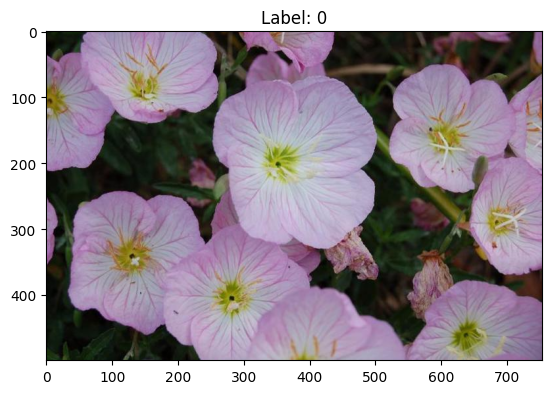

In [6]:
# image, label = train_set[0]
# image = image.permute(1, 2, 0)
# plt.imshow(image)
# plt.title(f'Label: {label}')
# plt.show()

In [7]:

# def inspect_image_sizes(dataset, num_images=10):
#     sizes = []
#     for i in range(num_images):
#         image, _ = dataset[i]
#         # Convert tensor back to PIL Image to check size
#         image = transforms.ToPILImage()(image)
#         sizes.append(image.size)

#     return sizes

# # Check sizes of first 10 images in the train, test, and validation sets
# train_image_sizes = inspect_image_sizes(train_set)
# test_image_sizes = inspect_image_sizes(test_set)
# val_image_sizes = inspect_image_sizes(val_set)

# print("Train Image Sizes:", train_image_sizes)
# print("Test Image Sizes:", test_image_sizes)
# print("Validation Image Sizes:", val_image_sizes)


Train Image Sizes: [(754, 500), (624, 500), (667, 500), (750, 500), (500, 714), (667, 500), (750, 500), (667, 500), (500, 654), (578, 500)]
Test Image Sizes: [(523, 500), (666, 500), (595, 500), (553, 500), (500, 601), (609, 500), (524, 500), (556, 500), (666, 500), (692, 500)]
Validation Image Sizes: [(606, 500), (667, 500), (500, 628), (500, 750), (752, 500), (662, 500), (666, 500), (646, 500), (626, 500), (593, 500)]


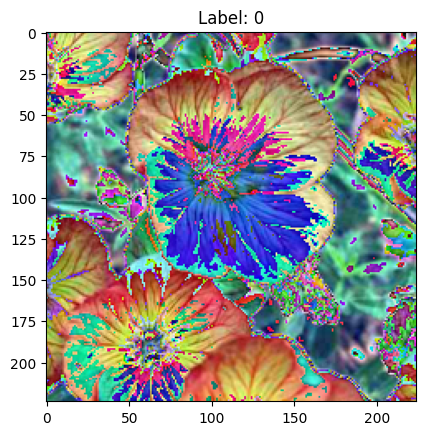

In [20]:
# def show_image(dataset, index=0):
#     image, label = dataset[index]
#     image = transforms.ToPILImage()(image)
#     plt.imshow(image)
#     plt.title(f'Label: {label}')
#     plt.show()

# show_image(train_set)


In [66]:
data_transform = transforms.Compose([
    transforms.Resize(128),
    transforms.CenterCrop(116),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])



In [34]:
def show_image(dataset, index=0):
    image, label = dataset[index]
    image = transforms.ToPILImage()(image)
    plt.imshow(image)
    plt.title(f'Label: {label}')
    plt.show()

# show_image(train_set)


In [67]:

train_set = datasets.Flowers102(root='data', split='train', download=True, transform=data_transform)
test_set = datasets.Flowers102(root='data', split='test', download=True, transform=data_transform)
val_set = datasets.Flowers102(root='data', split='val', download=True, transform=data_transform)


# create data loaders

train_loader = DataLoader(dataset=train_set, batch_size=16, shuffle=True)
test_loader = DataLoader(test_set, batch_size=32, shuffle=False)
val_loader = DataLoader(dataset=val_set, batch_size=16, shuffle=False)


for X, y in test_loader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break


Shape of X [N, C, H, W]: torch.Size([32, 3, 116, 116])
Shape of y: torch.Size([32]) torch.int64


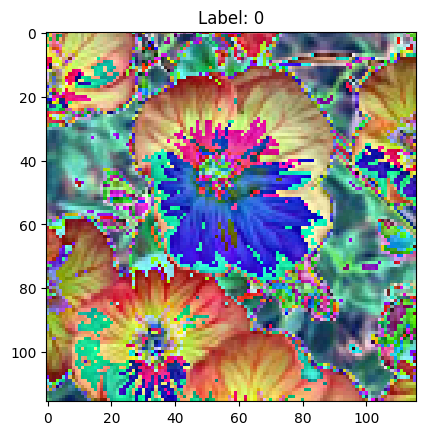

In [68]:
show_image(train_set)

## using the datasets.Flowers102 function

# preprocess data for training


# NN Architecture(Neural Network)


In [7]:
device = (
    'cuda'
    if torch.cuda.is_available()
    else 'mps'
    if torch.backends.mps.is_available()
    else 'cpu'
)
print(f'Using {device} device')

Using cuda device


## define the model

In [140]:
class ConvNN(nn.Module):
    # def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
    #     super().__init__()
    #     self.layer_stack = nn.Sequential(
    #         nn.Flatten(), # neural networks like their inputs in vector form
    #         nn.Linear(in_features=input_shape, out_features=hidden_units), # in_features = number of features in a data sample (784 pixels)
    #         nn.Linear(in_features=hidden_units, out_features=output_shape)
    #     )

    # def forward(self, x):
    #     return self.layer_stack(x)

    def __init__(self, hidden_units=32):
         super(ConvNN, self).__init__()
         self.hidden_units=hidden_units
         self.conv1 = nn.Conv2d(3, 32, kernel_size=5, padding=1, bias=True)
         self.conv2 = nn.Conv2d(32, 64, kernel_size=5, padding=1, bias=True)
         self.conv3 = nn.Conv2d(64, hidden_units, kernel_size=5, padding=1, bias=True)
         self.bn1 = nn.BatchNorm2d(32)
         self.bn2 = nn.BatchNorm2d(64)
         self.bn3 = nn.BatchNorm2d(hidden_units)

         self.pool = nn.MaxPool2d(2, 2)
         self.fc1 = nn.Linear(hidden_units * 12 * 12, 512)
         self.fc2 = nn.Linear(512, 102)
         # self.dropout1 = nn.Dropout(0.15)
         self.dropout2 = nn.Dropout(0.5)




        #x = self.pool(F.relu(self.bn1(self.conv1(x))))
        #x = self.pool(F.relu(self.bn2(self.conv2(x))))


        #x = F.relu(self.fc1(x))
        #
        #x = self.fc2(x)
        #return x
        #x = self.flatten(x)
        #logits = self.linear_relu_stack(x)
        #return logits
    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        # x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        # x = F.relu(self.conv3(x))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        # x = self.pool(F.relu(self.conv2(x)))

        # print(x.shape)
        x = x.view(-1, self.hidden_units * 12 * 12) # Flatten the output for the dense layer
        x = F.relu(self.fc1(x))
        # x = self.dropout1(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        return x





In [18]:
def train(dataloader, model, loss_fn, optimizer):
    total_loss = 0
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        optimizer.zero_grad()
        outputs = model(X)
        loss = loss_fn(outputs, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        if batch % 10 == 0:
            print(f'Epoch {t+1}, Batch {batch}, Loss: {loss.item():.4f}')

        # Time each batch processing
        if batch == 0:
            start_time = time.time()
        elif batch == 1:
            elapsed_time = time.time() - start_time
            print(f"Time per batch: {elapsed_time:.2f} seconds")

    average_loss = total_loss / len(dataloader)
    print(f'Average Loss: {average_loss:.4f}')

In [10]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [141]:
model = ConvNN(hidden_units=128).to(device)
print(model)

# LossFN
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
  # Lower learning rate
#optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)



ConvNN(
  (conv1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=18432, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=102, bias=True)
  (dropout2): Dropout(p=0.5, inplace=False)
)


# Train and Evaluation


In [142]:
epochs = 100
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_loader, model, loss_fn, optimizer)
    #if t > 20:
    test(val_loader, model, loss_fn)
print("Done!")


Epoch 1
-------------------------------
Epoch 1, Batch 0, Loss: 4.7000
Time per batch: 0.09 seconds
Epoch 1, Batch 10, Loss: 9.0790
Epoch 1, Batch 20, Loss: 5.6116
Epoch 1, Batch 30, Loss: 4.4651
Epoch 1, Batch 40, Loss: 4.4633
Epoch 1, Batch 50, Loss: 4.7388
Epoch 1, Batch 60, Loss: 4.6009
Average Loss: 6.1173
Test Error: 
 Accuracy: 3.0%, Avg loss: 4.516616 

Epoch 2
-------------------------------
Epoch 2, Batch 0, Loss: 4.7150
Time per batch: 0.09 seconds
Epoch 2, Batch 10, Loss: 4.5992
Epoch 2, Batch 20, Loss: 4.5609
Epoch 2, Batch 30, Loss: 4.2510
Epoch 2, Batch 40, Loss: 4.6279
Epoch 2, Batch 50, Loss: 4.4857
Epoch 2, Batch 60, Loss: 4.4253
Average Loss: 4.5212
Test Error: 
 Accuracy: 3.4%, Avg loss: 4.377806 

Epoch 3
-------------------------------
Epoch 3, Batch 0, Loss: 4.4992
Time per batch: 0.09 seconds
Epoch 3, Batch 10, Loss: 4.3400
Epoch 3, Batch 20, Loss: 4.3238
Epoch 3, Batch 30, Loss: 4.3272
Epoch 3, Batch 40, Loss: 4.1246
Epoch 3, Batch 50, Loss: 3.9847
Epoch 3, Bat

## split and format the dataset

In [ ]:
torch.save(model.state_dict(), "model.pth")
print("Saved PyTorch Model State to model.pth")

In [ ]:
model = ConvNN().to(device)
model.load_state_dict(torch.load("model.pth"))

## Set training parameters

## train

# Eval

In [ ]:
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the test images: {100 * correct / total} %')
